In [46]:
# !pip install jours-feries-france -q
# !pip install vacances-scolaires-france -q

In [67]:
import numpy as np
import pandas as pd

TARGETS = ["Available", "Charging", "Passive", "Other"]

In [95]:
# data loading
df_data = pd.read_csv("../public_data/train.csv")
# df_test = pd.read_csv("../public_data/test.csv")

df_data['date'] = pd.to_datetime(df_data['date'])

df_train = df_data[(df_data["date"] < "2021-01-18") & (df_data["date"] > "2020-09-30")]
df_validation = df_data[df_data["date"] > "2021-01-18"]

df_train["day"] = df_train.date.dt.date
df_validation["day"] = df_validation.date.dt.date

/var/folders/b0/nl_f0s110lxgs62v2c6jwdx40000gn/T/ipykernel_83327/567548462.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["day"] = df_train.date.dt.date
/var/folders/b0/nl_f0s110lxgs62v2c6jwdx40000gn/T/ipykernel_83327/567548462.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation["day"] = df_validation.date.dt.date


In [96]:
def sae(y_true, y_pred):
    """Sum of Absolute errors"""
    return(sum(abs(y_true - y_pred)))

# Station Level

In [97]:
s_naive = (
    df_train
    .drop(["date", "trend", "Latitude", "Longitude"], axis=1)
    .groupby(['Station', 'tod', 'dow'])
    .mean()
    .round()
    .reset_index()
)

In [98]:
station_prediction = pd.merge(
    df_validation.drop(TARGETS, axis=1), 
    s_naive, 
    on=['Station', 'tod', 'dow']
).sort_values(by=["date", "Station"])

In [99]:
sum(sae(df_validation[TARGETS].values, station_prediction[TARGETS].values) / df_validation["date"].nunique())

161.87756431129924

# Global Level

In [133]:
g_naive = (
    df_train
    .drop(["date", "trend"], axis=1)
    .groupby(['tod', 'dow'])
    .mean()
    .reset_index() * 91
)

test_global = df_validation.groupby('date').agg(
    {'tod': 'max',
    'dow': 'max',
    'trend': 'max'}
).reset_index()

global_truth = df_validation.groupby(["date", "tod", "dow"])[TARGETS].sum()

global_prediction = pd.merge(
    test_global,
    g_naive,
    on=['tod', 'dow']
)

In [126]:
train_truth = df_train.groupby(["date", "tod", "dow"])[TARGETS].sum()
train_truth

,,,Available,Charging,Passive,Other
date,tod,dow,,,,
2020-09-30 00:15:00,1,4,168,25,21,59
2020-09-30 00:30:00,2,4,169,25,20,59
2020-09-30 00:45:00,3,4,169,24,21,59
2020-09-30 01:00:00,4,4,170,24,20,59
2020-09-30 01:15:00,5,4,172,20,22,59
...,...,...,...,...,...,...
2021-01-17 22:45:00,91,1,118,24,17,81
2021-01-17 23:00:00,92,1,116,23,20,81
2021-01-17 23:15:00,93,1,117,23,19,81


In [120]:
global_truth[TARGETS]

,,,Available,Charging,Passive,Other
date,tod,dow,,,,
2021-01-18 00:15:00,1,2,118,26,19,77
2021-01-18 00:30:00,2,2,118,29,16,77
2021-01-18 00:45:00,3,2,114,28,18,80
2021-01-18 01:00:00,4,2,113,28,19,80
2021-01-18 01:15:00,5,2,114,26,20,80
...,...,...,...,...,...,...
2021-02-18 22:45:00,91,5,141,22,14,96
2021-02-18 23:00:00,92,5,139,22,16,96
2021-02-18 23:15:00,93,5,136,24,14,99


# Modeling

In [104]:
from jours_feries_france import JoursFeries

jf = list(JoursFeries.for_year(2020).values()) + list(JoursFeries.for_year(2021).values())

In [105]:
from vacances_scolaires_france import SchoolHolidayDates

holidays = SchoolHolidayDates()
hd = [k for k, v in holidays.holidays_for_year(2020).items() if v["vacances_zone_c"]] \
   + [k for k, v in holidays.holidays_for_year(2021).items() if v["vacances_zone_c"]]

In [106]:
df_train["is_jf"] = df_train["date"].dt.date.isin(jf)
df_train["is_hd"] = df_train["date"].dt.date.isin(hd)

/var/folders/b0/nl_f0s110lxgs62v2c6jwdx40000gn/T/ipykernel_83327/2766484269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_jf"] = df_train["date"].dt.date.isin(jf)
/var/folders/b0/nl_f0s110lxgs62v2c6jwdx40000gn/T/ipykernel_83327/2766484269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_hd"] = df_train["date"].dt.date.isin(hd)


In [107]:
df_train["is_jf"].mean()

0.03521400519042665

In [109]:
df_train["is_hd"].mean()

0.28705990062379577

In [110]:
df_train.groupby("is_hd")[TARGETS].mean().round(2)

,Available,Charging,Passive,Other
is_hd,,,,
False,1.80,0.30,0.29,0.61
True,1.76,0.27,0.42,0.55


<AxesSubplot:xlabel='date'>

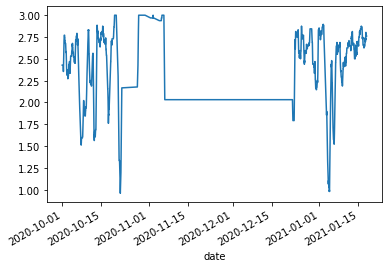

In [115]:
df_train.query("Station == 'FR*V75*EBELI*1*1'").set_index("date")["Available"].rolling(4*24).mean().plot()

In [ ]:
df_train["Available"]